In [1]:
import thejoker as tj
import astropy.units as u
from astropy.time import Time
import ast
import pymc as pm
import corner
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
bjd = np.loadtxt('rvdata.txt', usecols=0)
rv = np.loadtxt('rvdata.txt', usecols=1)*u.km/u.s
erv = np.loadtxt('rvdata.txt', usecols=2)*u.km/u.s

data = tj.RVData(t = bjd, rv = rv, rv_err = erv)
prior = tj.JokerPrior.default(P_min=2*u.day,P_max=3*u.day,sigma_K0=10*u.km/u.s,sigma_v=10*u.km/u.s)
joker = tj.TheJoker(prior)
prior_samples = prior.sample(size=100000)
samples = joker.rejection_sample(data, prior_samples)

In [3]:
print(samples)
print(samples['P'], samples['e'], samples['K'], samples['v0'])

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>
[2.77381769] d [0.02842552] [78.02635686] km / s [17.84151884] km / s


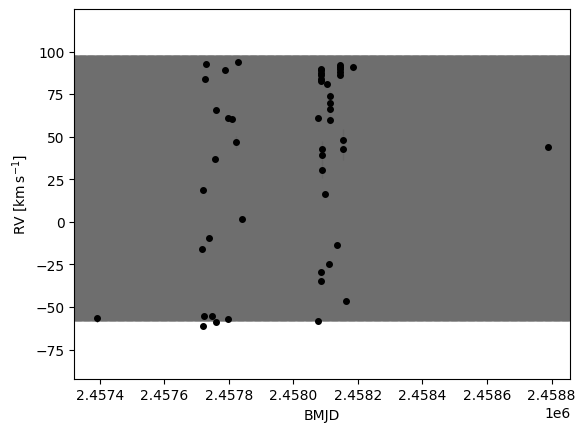

In [4]:
_ = tj.plot_rv_curves(samples, data=data)

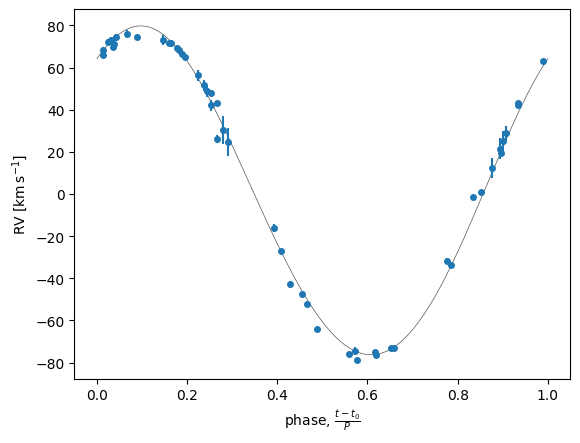

In [5]:
a = tj.plot_phase_fold(samples[0], data=data)

In [6]:
with prior.model:
    mcmc_init = joker.setup_mcmc(data, samples)
    trace = pm.sample(tune=1000, draws=1000, initvals=mcmc_init, cores=8, chains=8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 298 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
# mcmc_samples = joker.trace_to_samples(trace, data)
mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
mcmc_samples.wrap_K()

<JokerSamples [P, e, omega, M0, s, K, v0, ln_posterior, ln_likelihood, ln_prior] (7960 samples)>

In [8]:
lnp = mcmc_samples['ln_posterior'].value
index_sort = np.argsort(lnp)

Text(0.5, 0, 'ln_posterior')

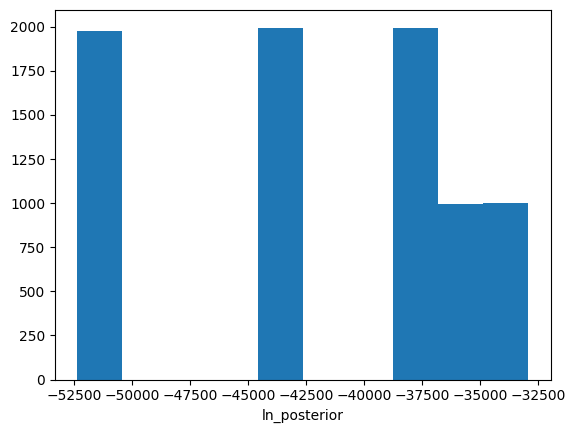

In [9]:
plt.hist(lnp)
plt.xlabel('ln_posterior')

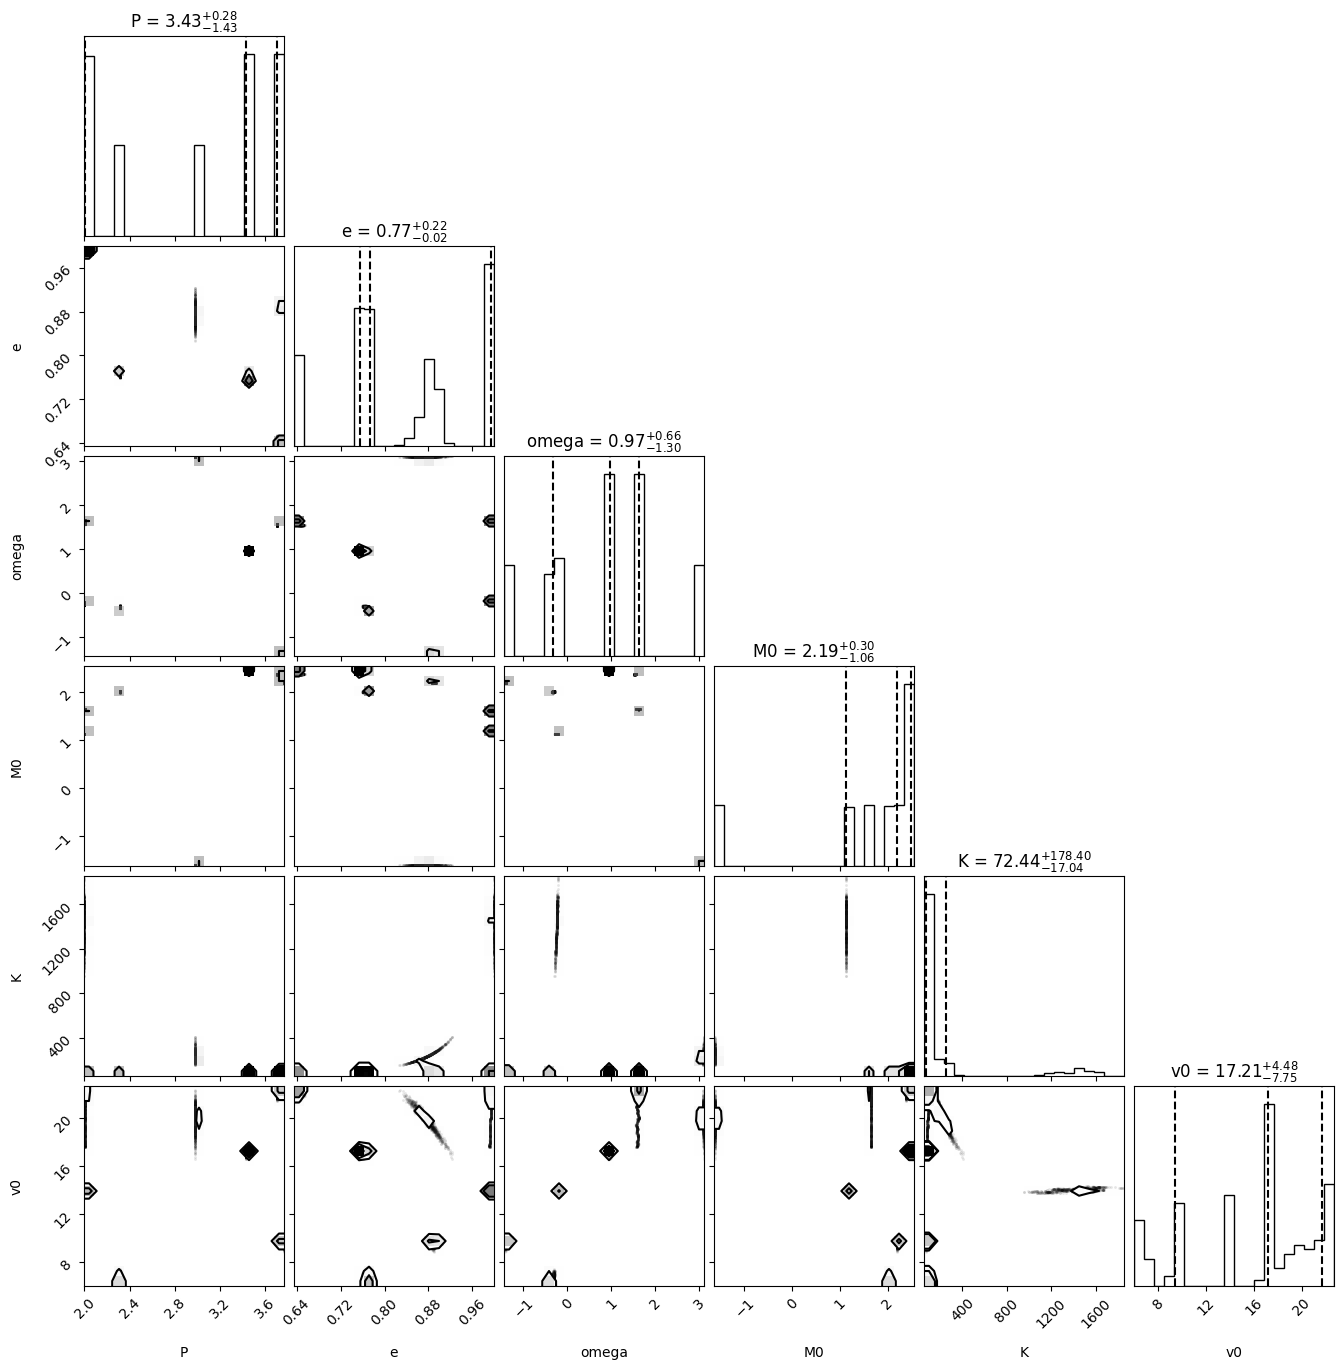

In [10]:
df = mcmc_samples.tbl.to_pandas()
# df = df[index_sort]
colnames = ['P', 'e', 'omega', 'M0', 'K', 'v0']
P = df['P']
e = df['e']
omega = df['omega']
M0 = df['M0']
K = df['K']
v0 = df['v0']

dd = np.stack((P[index_sort], e[index_sort], omega[index_sort], M0[index_sort], K[index_sort], v0[index_sort])).T

fig = corner.corner(dd[int(len(dd)*0):int(len(dd)*1)], labels=colnames, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})

In [11]:
np.mean(mcmc_samples['P'].value)

2.9591071397292192

In [12]:
pp = mcmc_samples['P'].value
lnp = mcmc_samples['ln_posterior'].value

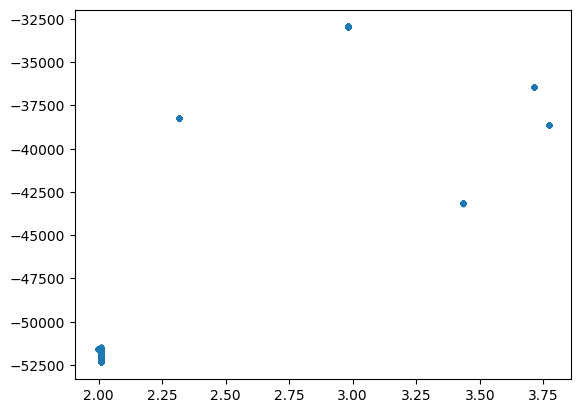

In [13]:
plt.plot(pp, lnp, '.')

In [14]:
df.sort_values

<bound method DataFrame.sort_values of              P         e     omega        M0    s          K         v0  \
0     3.434725  0.756776  0.960819  2.496330  0.0  55.253345  17.276036   
1     3.434685  0.764226  0.985396  2.508102  0.0  55.675436  17.097449   
2     3.434682  0.765514  0.979513  2.513837  0.0  55.760384  17.005935   
3     3.434730  0.756460  0.951750  2.487640  0.0  55.384125  17.448498   
4     3.434743  0.754313  0.951263  2.483364  0.0  55.398512  17.468833   
...        ...       ...       ...       ...  ...        ...        ...   
7955  3.770370  0.890278 -1.432662  2.193096  0.0  71.804269   9.915144   
7956  3.770382  0.891317 -1.426861  2.190840  0.0  71.144784   9.926951   
7957  3.770383  0.891528 -1.415490  2.191154  0.0  71.256829  10.011357   
7958  3.770376  0.892068 -1.414262  2.192655  0.0  72.497735   9.441755   
7959  3.770387  0.891196 -1.429097  2.189735  0.0  72.727407   9.473198   

      ln_posterior  ln_likelihood   ln_prior  
0    -43158.1

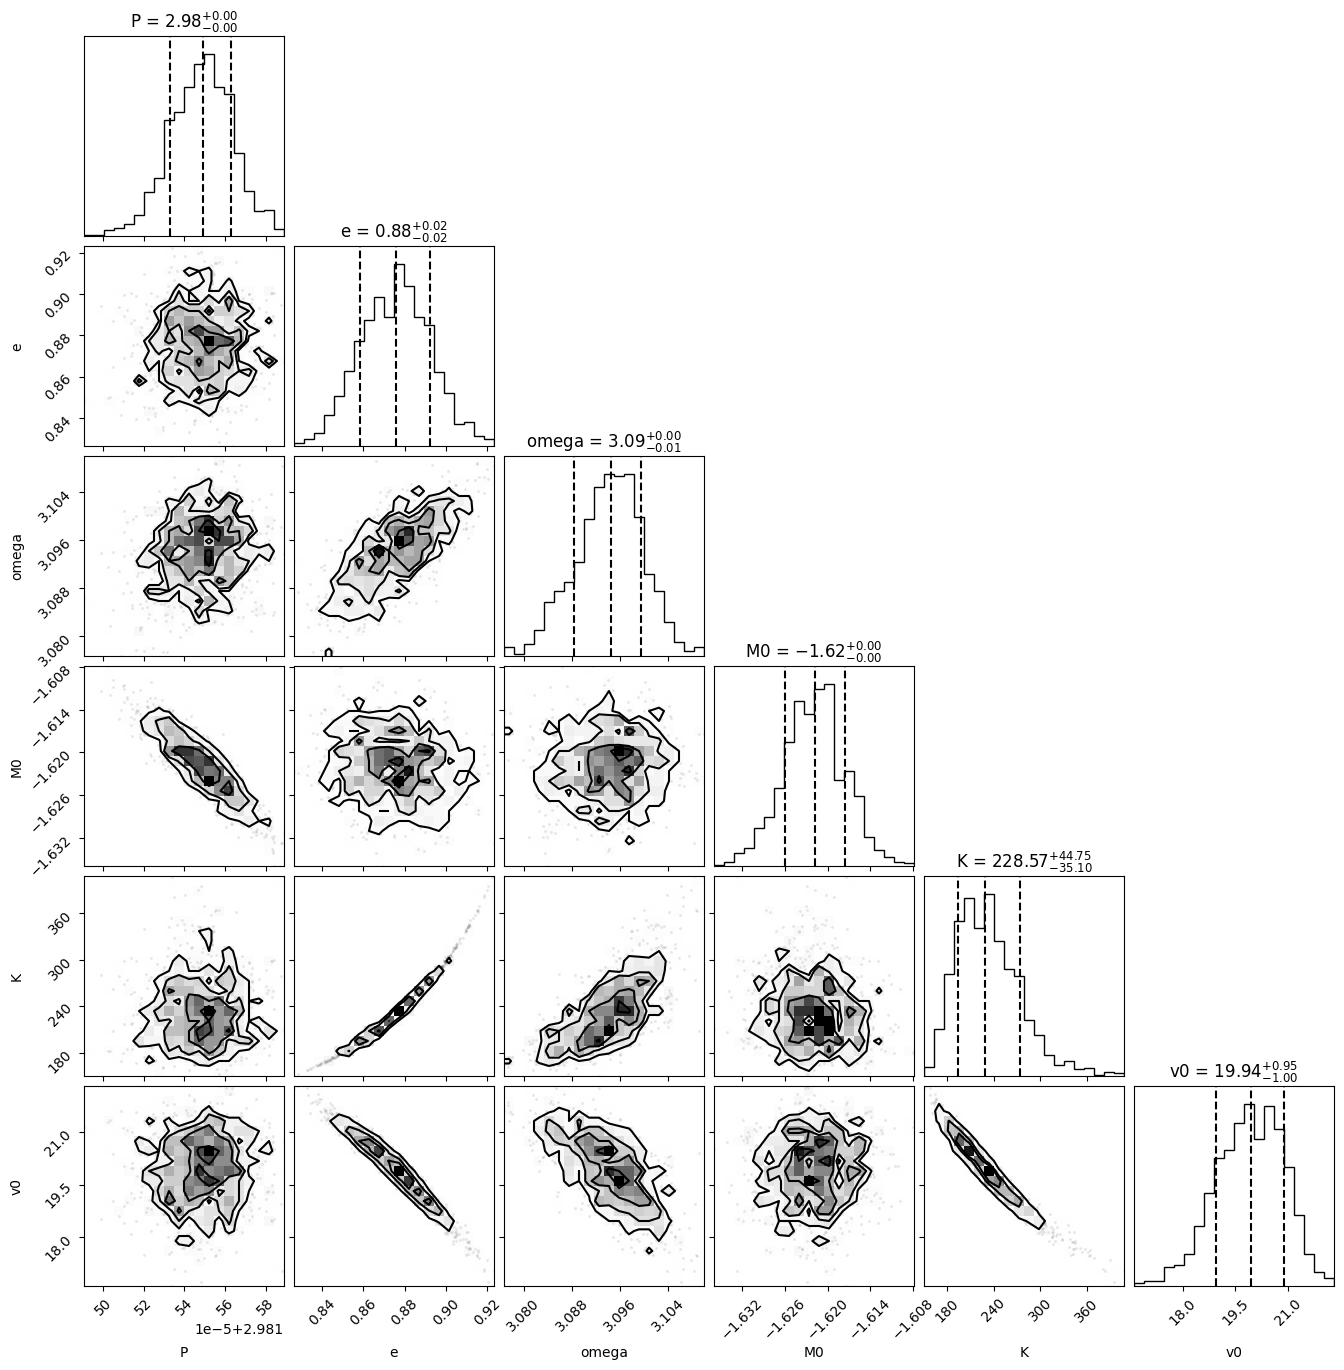

In [15]:
fig = corner.corner(dd[int(len(dd)*0.875):int(len(dd)*1)], labels=colnames, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})